#### Running a Bell circuit on different backends

In [1]:
from qiskit_braket_provider import AWSBraketProvider
from qiskit_braket_provider.providers import adapter
from braket.aws import AwsSession

from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import SparsePauliOp
from qiskit.primitives import BackendEstimator

aws_session = AwsSession(default_bucket="amazon-braket-us-west-1-lukasvoss")
AWSBraketProvider().backends()

[BraketBackend[Aria 1],
 BraketBackend[Aria 2],
 BraketBackend[Aspen-M-3],
 BraketBackend[Forte 1],
 BraketBackend[Harmony],
 BraketBackend[Lucy],
 BraketBackend[SV1],
 BraketBackend[dm1]]

Qiskit Bell Circuit

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


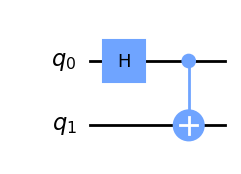

In [2]:
qiskit_qc = QuantumCircuit(2)
qiskit_qc.h(0)
qiskit_qc.cx(0, 1)

qiskit_qc.draw("mpl")

Braket Circuit from Qiskit Circuit

In [3]:
braket_qc = adapter.convert_qiskit_to_braket_circuit(qiskit_qc)
print(braket_qc)

T  : |0|1|
          
q0 : -H-C-
        | 
q1 : ---X-

T  : |0|1|


Set the backend to AWS Braket Provider SV1

In [4]:
backend = AWSBraketProvider().get_backend('SV1')

Run on AWS Qiskit-Braket Provider

In [5]:
# job = [backend.run(qiskit_qc, shots=100).result() for i in range(3)]

In [6]:
# counts = [j.results[0].data.counts for j in job]
# counts

[{'11': 53, '00': 47}, {'11': 53, '00': 47}, {'00': 52, '11': 48}]

Run with native Braket SV Backend

In [7]:
# device = backend._device
# job_braket_native = device.run_batch(
#     braket_qc,
#     shots=100
# )

In [8]:
# job_braket_native.results()[0].measurement_counts

Counter({'00': 56, '11': 44})

Run with Braket Provider + **Estimator Primitive**

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


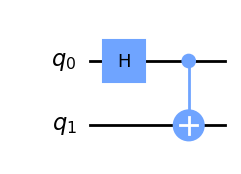

In [21]:
qiskit_qc.draw("mpl")

In [22]:
backend = AWSBraketProvider().get_backend('SV1')
estimator = BackendEstimator(backend)
observables = SparsePauliOp.from_list(([('XX', 0.25), ("IZ", 0.25), ("ZZ", 0.25), ("XY", 0.25)]))
job = estimator.run(
    circuits=qiskit_qc,
    observables=observables,
    shots=100
)
job.result().values

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit_braket_provider/providers/adapter.py:475: UserWarning: Device does not support global phase; global phase of 1.5707963267948966 will not be included in Braket circuit
  warnings.warn(
/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit_braket_provider/providers/adapter.py:475: UserWarning: Device does not support global phase; global phase of 2.3561944901923457 will not be included in Braket circuit
  warnings.warn(
/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit_braket_provider/providers/adapter.py:475: UserWarning: Device does not support global phase; global phase of 4.71238898038469 will not be included in Braket circuit
  warnings.warn(


array([0.47])

In [10]:
estimator = BackendEstimator(backend)

In [11]:
observables = SparsePauliOp.from_list(([('ZZ', 1.0)]))

In [15]:
job = estimator.run(
    circuits=qiskit_qc,
    observables=observables,
    shots=100
)

In [18]:
print(job.status())

JobStatus.DONE


In [19]:
job.result().values

array([1.])

#### Measuring a sum of scaled observables in native Braket

In [ ]:
from braket.devices import LocalSimulator
from braket.circuits import Circuit, Observable
from braket.circuits.observables import TensorProduct
from braket.quantum_information import PauliString

In [ ]:
circuit = Circuit()
circuit.x(0)

observable_2q = TensorProduct([0.25*Observable.X(), 0.25*Observable.Z()])  # Observable.Z() @ Observable.Z() # + 0.25*Observable.Z() @ Observable.Z()

circuit.expectation(observable=observable_2q, target=[0, 1])
print(circuit)

# Set the device to run your circuit
device = LocalSimulator()

# Run the circuit with the observable to measure the expectation value
task = device.run(circuit, shots=1000)

# Get the result
result = task.result()

# # Extract the expectation value from the result
expectation_values = result.values

print(f"\nExpectation value: {expectation_values}")

A non-scaled (no prefactor) sum of pauli operators CAN be measured

In [ ]:
circuit = Circuit()
circuit.x(0)

# Define observables for each qubit
observable_2q = Observable.X()@Observable.X() + Observable.Z()@Observable.Z()

# Measure the expectation value for 2-qubit observable
circuit.expectation(observable=observable_2q, target=[[0, 1], [0, 1]])

# Measure the expectation value for the observable on qubit 1
# circuit.expectation(observable=observable_q1, target=[[1], [1]])

print(circuit)

# Set the device to run your circuit
device = LocalSimulator()

# Run the circuit with the observable to measure the expectation value
task = device.run(circuit, shots=1000)

# Get the result
result = task.result()

# # Extract the expectation value from the result
expectation_values = result.values

print(f"\nExpectation value: {expectation_values}")

In [ ]:
circuit = Circuit()
circuit.x(0)

# Pauli String without a prefactor works
# observable_2q = PauliString("XX").to_unsigned_observable()

# Pauli String WITH a prefactor FAILS
observable_2q = 0.25*PauliString("XX").to_unsigned_observable()

# Measure the expectation value for 2-qubit observable
circuit.expectation(observable=observable_2q, target=[0, 1])

# Measure the expectation value for the observable on qubit 1
# circuit.expectation(observable=observable_q1, target=[[1], [1]])

print(circuit)

# Set the device to run your circuit
device = LocalSimulator()

# Run the circuit with the observable to measure the expectation value
task = device.run(circuit, shots=1000)

# Get the result
result = task.result()

# # Extract the expectation value from the result
expectation_values = result.values

print(f"\nExpectation value: {expectation_values}")